In [1]:
using ITensors
using HDF5
using Plots
using Plots.PlotMeasures

Load in the trained MPS

In [3]:
f = h5open("ECG200_pix.h5", "r");
W = read(f, "MPS", MPS);

# Slice the MPS

In [4]:
findindex(W[end], "f(x)")

(dim=2|id=776|"f(x)")

In [5]:
norm(W)

0.9999999999999981

In [6]:
function SliceMPS(W::MPS)
    """Gets the label index of the MPS and slices according to the number of classes (dim of the label index)"""
    """Assume one-hot encoding scheme i.e. class 0 = [1, 0], class 1 = [0, 1], etc. """
    dec_index = findindex(W[end], "f(x)")
    if dec_index == nothing
        error("Label index not found on the first site of the MPS!")
    end

    n_states = ITensors.dim(dec_index)
    states = []
    for i=1:n_states
        state = deepcopy(W)
        if !isapprox(norm(state), 0)
            normalize!(state)
        end
        decision_state = onehot(dec_index => (i))
        println("Class $(i-1) state: $(vector(decision_state))")
        state[end] *= decision_state
        normalize!(state)
        push!(states, state)
    end

    return states
end;

In [7]:
s0, s1 = SliceMPS(W);

Class 0 state: [1.0, 0.0]


Class 1 state: [0.0, 1.0]


In [8]:
function entropy_von_neumann(ψ::MPS, b::Int)
    psi = deepcopy(ψ)
    s = siteinds(psi)
    orthogonalize!(psi, b) # change orthogonality center to site B
    #print(norm(psi))
    if b == 1
        _, S = svd(psi[b], (siteind(psi, b),))
    else
        _, S = svd(psi[b], (linkind(psi, b-1), s[b]))
    end
    SvN = 0.0
    for n in 1:ITensors.dim(S, 1)
        p = S[n, n]^2
        if p > 1E-12
            SvN -= p * log(p)
        end
    end

    return SvN
end;

In [9]:
entropy_s0 = [entropy_von_neumann(s0, site_idx) for site_idx in 1:length(s0)]
entropy_s1 = [entropy_von_neumann(s1, site_idx) for site_idx in 1:length(s1)]

96-element Vector{Float64}:
  0.30363032691169
  0.5823486365385725
  0.8926977365771755
  1.1362667256978445
  1.4309517146469832
  1.753632669562225
  1.9801972709109337
  2.1579414817834834
  2.2517463135942584
  2.273431321922591
  ⋮
  1.5011047125709764
  1.4350574775834775
  1.3593399145895206
  1.2404001301163157
  1.0983819859218462
  0.8389670140718007
  0.5440516176115464
  0.22034738834225773
 -6.217248937900896e-15

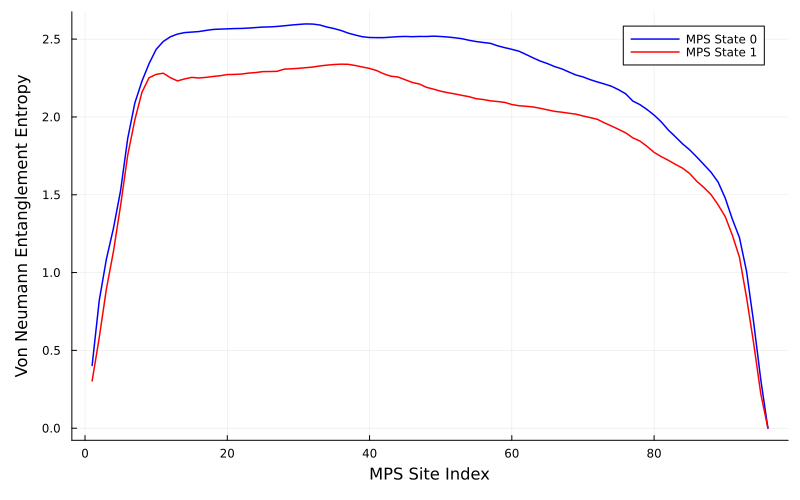

In [10]:
plot(entropy_s0, label="MPS State 0", lw=1.5, color=:blue, size=(800,500), left_margin=5mm, bottom_margin=5mm)
plot!(entropy_s1, label="MPS State 1", lw=1.5, color=:red)
xlabel!("MPS Site Index")
ylabel!("Von Neumann Entanglement Entropy")

# Start with state 0

In [11]:
s0_copy = deepcopy(s0);

In [12]:
orthogonalize!(s0_copy, 1);

In [13]:
s = siteinds(s0_copy);

Get the 1-site RDM for site 1

In [14]:
ρ1 = prime(s0_copy[1], s[1]) * dag(s0_copy[1])
ρ1 = matrix(ρ1)

2×2 Matrix{Float64}:
  0.282265  -0.288114
 -0.288114   0.717735

In [15]:
tr(ρ1), isequal(ρ1, adjoint(ρ1))

(0.999999999999998, true)

Construct interval from $\theta = 0$ to $\theta = \pi/2$ and discretise into 100 values.

In [16]:
theta_range = collect(range(0, pi, 100));
states = [[cos(theta), sin(theta)] for theta in theta_range];

Map each value to its corresponding state vector. Let's try the $\ket{0}$ state.

In [18]:
psi = states[1]

2-element Vector{Float64}:
 1.0
 0.0

The probability of the $\ket{0}$ state is given by $\braket{\psi | \rho | \psi}$ where $\rho$ is the 1 site RDM and $\ket{\psi}$ is the target state.

In [19]:
proba_0_state = psi' * ρ1 * psi

0.2822651560446343

So we have a probability of 0.31900827364146045 of being in the zero state. Now let's repeat for all states in the interval.

In [20]:
probas = []
for i=1:length(states)
    psi = states[i]
    expect = psi' * ρ1 * psi
    push!(probas, expect)
end

In [31]:
probas

100-element Vector{Any}:
 0.2822651560446343
 0.26443022815091627
 0.24754385658555153
 0.2316740368068939
 0.21688467097803832
 0.20323531065536277
 0.19078091699543034
 0.1795716394458087
 0.16965261381094557
 0.16106378050621434
 ⋮
 0.4498124706754879
 0.4272312227201993
 0.4049429889477298
 0.38303751620898785
 0.36160301011129287
 0.34072577984552427
 0.3204898906494743
 0.30097682530680414
 0.2822651560446344

In [22]:
probas_normalised = probas ./ sum(probas);

In [23]:
using Distributions

In [24]:
dist = Categorical(probas_normalised)

Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(100)
p: [0.005669994227057822, 0.005311735561289726, 0.004972530996924612, 0.004653746391023031, 0.004356665376679917, 0.00408248419428713, 0.0038323068746956325, 0.0036071407936728883, 0.003407892615556213, 0.0032353646424354804  …  0.009493256375872408, 0.009035596698252527, 0.008581996447550661, 0.008134282111880997, 0.007694256478855293, 0.0072636913763934495, 0.006844320538197798, 0.0064378326226194335, 0.006045864413027008, 0.005669994227057824]
)


In [25]:
sampled_index = rand(dist)

68

In [26]:
states[sampled_index]

2-element Vector{Float64}:
 -0.5272254676105025
  0.8497254299495143

In [28]:
(acos(states[sampled_index][1])) / π

0.6767676767676768

Note that because we are calculating probabilites based on the assumption that the quantum system is independently observed to be in each specific state, these quantities reflect the absolute probability. We need to normalise the values to get the relative probabilities of being in each possible state in order to do sampling.

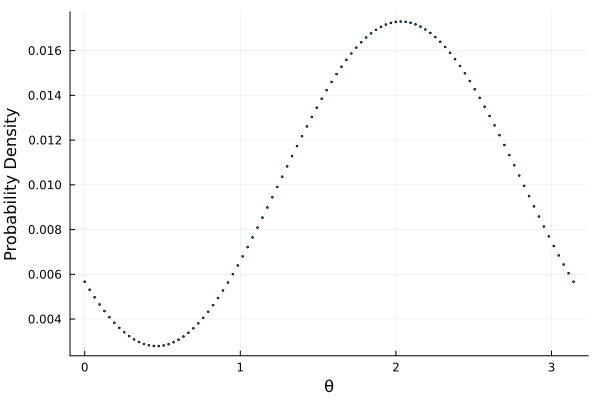

In [29]:
scatter(theta_range, probas_normalised, xlabel="θ", ylabel="Probability Density", label="", ms=1)

Now that we have our probabilities for each "bin"/discretised value, let's generate a sample using a random number generator and our cumulative distribution function above.

In [357]:
cdf = cumsum(probas_normalised)

100-element Vector{Float64}:
 0.004182768259646079
 0.008544010457813285
 0.013085857977774614
 0.017810260348553274
 0.022718983281912214
 0.02781360689443204
 0.03309552411646758
 0.03856593928958508
 0.044225866953892315
 0.05007613082648275
 ⋮
 0.9250332241751775
 0.9349812901315399
 0.9447706909874594
 0.9543980924305661
 0.9638603232681665
 0.973154378620366
 0.9822774229457282
 0.9912267928964246
 1.0000000000000004

Generate random value and then select a bin using the cdf..

In [358]:
r = rand()
sampled_bin_index = findfirst(>=(r), cdf)

7

Now convert the selected index back into a raw time-series value

In [359]:
selected_angle = theta_range[sampled_bin_index]

0.09519977738150888

In [360]:
states[sampled_bin_index]

2-element Vector{Float64}:
 0.9954719225730846
 0.09505604330418266

This is the value of $\theta$, our angle. We can then get back our original time-series value: $x = 2 \theta / \pi$

In [361]:
x = (2 * selected_angle) / pi

0.0606060606060606

In [362]:
acos(selected_angle)

1.4754521605406958

This is now our measurement for the first site. Let's construct a projector to project the MPS onto this state at the first site and continue our sampling process...

In [363]:
site_1_projector_matrix = states[sampled_bin_index] * states[sampled_bin_index]'

2×2 Matrix{Float64}:
 0.990964   0.0946256
 0.0946256  0.00903565

Convert the matrix into a single site MPO in ITensor

In [364]:
site_1_projector_operator = op(site_1_projector_matrix, s[1]);
@show site_1_projector_operator

site_1_projector_operator = ITensor ord=2
Dim 1: (dim=2|id=6|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=6|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 0.9909643486313533  0.0946256221802051
 0.0946256221802051  0.009035651368646648


ITensor ord=2 (dim=2|id=6|"S=1/2,Site,n=1")' (dim=2|id=6|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Make the measurement by applying the operator to site 1

In [365]:
site_1_before_measure = deepcopy(s0[1])

ITensor ord=2 (dim=2|id=6|"S=1/2,Site,n=1") (dim=2|id=396|"Link,l=1")
NDTensors.Dense{Float64, Vector{Float64}}

In [366]:
site_1_after_measure = site_1_before_measure * site_1_projector_operator

ITensor ord=2 (dim=2|id=396|"Link,l=1") (dim=2|id=6|"S=1/2,Site,n=1")'
NDTensors.Dense{Float64, Vector{Float64}}

Now unprime the site index before placing the new site back into the MPS

In [367]:
noprime!(site_1_after_measure)

ITensor ord=2 (dim=2|id=396|"Link,l=1") (dim=2|id=6|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Add back into MPS

In [368]:
s0[1] = site_1_after_measure

ITensor ord=2 (dim=2|id=396|"Link,l=1") (dim=2|id=6|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

In [369]:
norm(s0)

0.6384997603481029

Re-normalise

In [370]:
normalize!(s0);

### Site 2

We have conditioned our MPS on the first site, now let's get the RDM for the second site.

In [371]:
orthogonalize!(s0, 2);

In [372]:
ρ2 = prime(s0[2], s[2]) * dag(s0[2])
ρ2 = matrix(ρ2)

2×2 Matrix{Float64}:
 0.341257  0.397073
 0.397073  0.658743

In [373]:
tr(ρ2), isequal(ρ2, adjoint(ρ2))

(1.0000000000000098, true)

In [374]:
theta_range = collect(range(0, pi/2, 100));
states = [[cos(theta), sin(theta)] for theta in theta_range];

In [375]:
probas = []
for i=1:length(states)
    psi = states[i]
    expect = psi' * ρ2 * psi
    push!(probas, expect)
end

In [376]:
probas_normalised = probas ./ sum(probas);

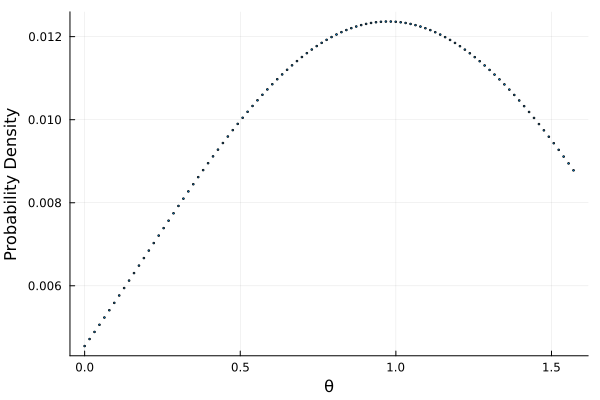

In [377]:
scatter(theta_range, probas_normalised, xlabel="θ", ylabel="Probability Density", label="", ms=1)

In [378]:
cdf = cumsum(probas_normalised)

100-element Vector{Float64}:
 0.004548657383454172
 0.009266304715406752
 0.014154902383722818
 0.019216238643769572
 0.024451927817794764
 0.029863408669441035
 0.03545194295503287
 0.04121861415309498
 0.047164326373381193
 0.05328980344651266
 ⋮
 0.9252242223804548
 0.9351187453968005
 0.9448626337764712
 0.954452786908653
 0.9638862589808949
 0.9731602619452918
 0.9822721683258128
 0.9912195138639462
 0.9999999999999998

In [379]:
r = rand()
sampled_bin_index = findfirst(>=(r), cdf)

49

In [380]:
selected_angle = theta_range[sampled_bin_index]

0.761598219052071

In [381]:
x = (2 * selected_angle) / pi

0.4848484848484848